In [2]:
import sys
from pathlib import Path
# Ensure project root is on sys.path for package imports
ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np

# Paths to raw data
path_vars = "../data/raw/PAKDD2010_VariablesList.XLS"
path_model = "../data/raw/PAKDD2010_Modeling_Data.txt"

# 1) Load column names from Excel
df_vars = pd.read_excel(path_vars)
colnames = df_vars['Var_Title'].astype(str).tolist()

# Fix column 43 name if needed (dataset quirk)
if len(colnames) > 43:
    colnames[43] = "MATE_" + colnames[43]

# 2) Load modeling dataset (tab-separated)
df = pd.read_csv(path_model, sep="\t", header=None, names=colnames, encoding="latin1", low_memory=False)

# 3) Normalize target column name
if 'TARGET_LABEL_BAD=1' in df.columns:
    df.rename(columns={'TARGET_LABEL_BAD=1': 'TARGET'}, inplace=True)

print("✅ df cargado correctamente")
print("📌 Shape:", df.shape)
print("🎯 Target:", 'TARGET')

df.head()

✅ df cargado correctamente
📌 Shape: (50000, 54)
🎯 Target: TARGET


,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


In [3]:
import pandas as pd
import numpy as np

from ml_creditrisk.feature_grouping import (
    compute_missing_pct,
    build_groups_raw,
    make_rectangular,
)

# ===============================
# ⚙️ Parámetros configurables
# ===============================
TARGET_COL = 'TARGET'
LOW_CARDINALITY_THRESHOLD = 20       # max categorías para cat_low
NUM_REAL_UNIQUE_MIN = 20             # min valores distintos para considerar "num_reales"
HIGH_MV_THRESHOLD = 60.0             # porcentaje de MV (NA+vacío) para excluir
STYLE_WARN_THRESHOLD = 50.0          # porcentaje de MV para resaltar en rojo en display

# ===============================
# 0) Preparación básica
# ===============================
# Eliminar ID_CLIENT si existe
if 'ID_CLIENT' in df.columns:
    df = df.drop(columns=['ID_CLIENT'])

# Copia de trabajo
df_model = df.copy()

# Constantes: variables con un solo valor (excluyendo TARGET)
unique_counts = df_model.nunique().sort_values()
single_value_cols = [col for col, cnt in unique_counts.items() if cnt <= 1 and col != TARGET_COL]
# quitarlas del dataset de trabajo (auditable: las mantenemos en df_groups_all como grupo, pero fuera de df_model)
df_model = df_model.drop(columns=single_value_cols, errors='ignore')

# ===============================
# 1) Crear los grupos (raw)
# ===============================
groups_raw, groups_lists = build_groups_raw(
    df_model=df_model,
    target_col=TARGET_COL,
    single_value_cols=single_value_cols,
    low_card_thres=LOW_CARDINALITY_THRESHOLD,
    num_real_unique_min=NUM_REAL_UNIQUE_MIN,
)

# ===============================
# 3) Missing% (NA + strings vacíos)
# ===============================
missing_pct = compute_missing_pct(df, treat_empty_as_missing=True)

# ===============================
# 4) Eliminar grupos y variables según condiciones
# ===============================
high_mv_set = {c for c, pct in missing_pct.items() if pct > HIGH_MV_THRESHOLD}

# Filtrar variables y eliminar por regla el grupo 'Un solo valor'
groups_filtered = {g: [c for c in cols if c not in high_mv_set and c in df.columns] for g, cols in groups_raw.items()}
rule_drop_groups = {'Un solo valor'}
groups_dropped_by_rule = [g for g in groups_filtered.keys() if g in rule_drop_groups]
# Final: sin grupos de regla y sin grupos vacíos
groups_final = {g: cols for g, cols in groups_filtered.items() if g not in rule_drop_groups and len(cols) > 0}

excluded_vars = sorted([c for c in high_mv_set if c in df.columns])
excluded_groups_empty = [g for g, cols in groups_filtered.items() if len(cols) == 0 and g not in rule_drop_groups]

print("\n📌 Exclusiones aplicadas:")
print(f" - Variables excluidas por MV > {HIGH_MV_THRESHOLD}%: {len(excluded_vars)}")
if excluded_vars:
    print('   Ejemplo (primeras 10):', excluded_vars[:10])
# Lista completa de variables del grupo 'Un solo valor' (eliminadas por regla)
un_solo_valor_vars = groups_raw.get('Un solo valor', [])
print(f" - Variables del grupo 'Un solo valor' eliminadas por regla: {len(un_solo_valor_vars)}")
if un_solo_valor_vars:
    print('   Lista (completa):', un_solo_valor_vars)
if groups_dropped_by_rule:
    print(f" - Grupos eliminados por regla: {groups_dropped_by_rule}")
print(f" - Grupos eliminados por quedar vacíos: {len(excluded_groups_empty)}")
if excluded_groups_empty:
    print('   Grupos eliminados (vacíos):', excluded_groups_empty)

# ===============================
# 5) DataFrame FINAL para preprocesamiento
# ===============================
df_groups_final = make_rectangular(groups_final, missing_pct)
# Alias por compatibilidad
df_groups = df_groups_final.copy()

# ===============================
# 🎨 Styling (resalta MV% > STYLE_WARN_THRESHOLD)
# ===============================
def _highlight_mv(cell):
    if cell is None:
        return ""
    try:
        import re
        m = re.search(r"([0-9]+(?:\.[0-9]+)?)%", str(cell))
        if not m:
            return ""
        pct = float(m.group(1))
        return "color: red" if pct > STYLE_WARN_THRESHOLD else ""
    except Exception:
        return ""

print("\n📌 DataFrame FINAL (variables y grupos que se usarán en pipelines):")
try:
    display(df_groups_final.style.map(_highlight_mv))
except Exception as e:
    print("(Styling falló, mostrando sin formato). Error:", e)
    display(df_groups_final)


📌 Exclusiones aplicadas:
 - Variables excluidas por MV > 60.0%: 5
   Ejemplo (primeras 10): ['MATE_EDUCATION_LEVEL', 'PROFESSIONAL_BOROUGH', 'PROFESSIONAL_CITY', 'PROFESSIONAL_PHONE_AREA_CODE', 'PROFESSIONAL_STATE']
 - Variables del grupo 'Un solo valor' eliminadas por regla: 9
   Lista (completa): ['CLERK_TYPE', 'QUANT_ADDITIONAL_CARDS', 'EDUCATION_LEVEL', 'FLAG_MOBILE_PHONE', 'FLAG_HOME_ADDRESS_DOCUMENT', 'FLAG_INCOME_PROOF', 'FLAG_CPF', 'FLAG_RG', 'FLAG_ACSP_RECORD']
 - Grupos eliminados por regla: ['Un solo valor']
 - Grupos eliminados por quedar vacíos: 0

📌 DataFrame FINAL (variables y grupos que se usarán en pipelines):


,binary,num_reales,cat_low,cat_high
0,POSTAL_ADDRESS_TYPE | MV 0.00%,MONTHS_IN_RESIDENCE | MV 7.55%,PAYMENT_DAY | MV 0.00%,STATE_OF_BIRTH | MV 4.13%
1,FLAG_RESIDENCIAL_PHONE | MV 0.00%,PERSONAL_MONTHLY_INCOME | MV 0.00%,MARITAL_STATUS | MV 0.00%,CITY_OF_BIRTH | MV 4.13%
2,FLAG_EMAIL | MV 0.00%,OTHER_INCOMES | MV 0.00%,QUANT_DEPENDANTS | MV 0.00%,RESIDENCIAL_STATE | MV 0.00%
3,FLAG_VISA | MV 0.00%,PERSONAL_ASSETS_VALUE | MV 0.00%,NACIONALITY | MV 0.00%,RESIDENCIAL_CITY | MV 0.00%
4,FLAG_MASTERCARD | MV 0.00%,MONTHS_IN_THE_JOB | MV 0.00%,RESIDENCE_TYPE | MV 2.70%,RESIDENCIAL_BOROUGH | MV 0.02%
5,FLAG_DINERS | MV 0.00%,AGE | MV 0.00%,QUANT_BANKING_ACCOUNTS | MV 0.00%,RESIDENCIAL_PHONE_AREA_CODE | MV 16.42%
6,FLAG_AMERICAN_EXPRESS | MV 0.00%,None,QUANT_SPECIAL_BANKING_ACCOUNTS | MV 0.00%,RESIDENCIAL_ZIP_3 | MV 0.00%
7,FLAG_OTHER_CARDS | MV 0.00%,None,PROFESSION_CODE | MV 15.51%,PROFESSIONAL_ZIP_3 | MV 0.00%
8,QUANT_CARS | MV 0.00%,None,OCCUPATION_TYPE | MV 14.63%,None
9,COMPANY | MV 0.00%,None,MATE_PROFESSION_CODE | MV 57.77%,None


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

from ml_creditrisk.preprocessing import build_preprocessor_from_groups, resumen_columnas

# ======================
# 🏗 ColumnTransformer desde df_groups_final
# ======================

preprocessor, lists = build_preprocessor_from_groups(df_groups_final, df_model)
print("\n✅ Preprocessor listo para entrenar modelos")

# ======================
# 📊 Resumen de columnas generadas
# ======================

X = df_model.drop(columns=['TARGET'])
y = df_model['TARGET']
resumen_columnas(preprocessor, X, y)

# División estratificada 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


✅ Preprocessor listo para entrenar modelos

📈 Resumen de columnas generadas por cada bloque:
  🔹 num_winsor   →    4 columnas (input: 4)
  🔹 num_bins     →    2 columnas (input: 2)
  🔹 binary       →   11 columnas (input: 11)
  🔹 cat_low      →  103 columnas (input: 13)
  🔹 cat_high     →    8 columnas (input: 8)
  ⚙️  Total columnas generadas: 128

  🔹 num_winsor   →    4 columnas (input: 4)
  🔹 num_bins     →    2 columnas (input: 2)
  🔹 binary       →   11 columnas (input: 11)
  🔹 cat_low      →  103 columnas (input: 13)
  🔹 cat_high     →    8 columnas (input: 8)
  ⚙️  Total columnas generadas: 128




🔎 Umbral de importancia = 0.02
✅ Variables conservadas: 14 | ❌ Eliminadas: 24
❌ Eliminadas (24) con su importancia y umbral:


,variable,importance,threshold
0,RESIDENCIAL_CITY,0.018649,0.02
1,FLAG_MASTERCARD,0.014452,0.02
2,RESIDENCIAL_PHONE_AREA_CODE,0.013895,0.02
3,CITY_OF_BIRTH,0.013834,0.02
4,RESIDENCIAL_BOROUGH,0.013832,0.02
5,QUANT_BANKING_ACCOUNTS,0.010964,0.02
6,FLAG_PROFESSIONAL_PHONE,0.010728,0.02
7,PERSONAL_MONTHLY_INCOME,0.010159,0.02
8,OTHER_INCOMES,0.009898,0.02
9,FLAG_VISA,0.009836,0.02


✅ preprocessor_filtered creado con las variables por encima del umbral.


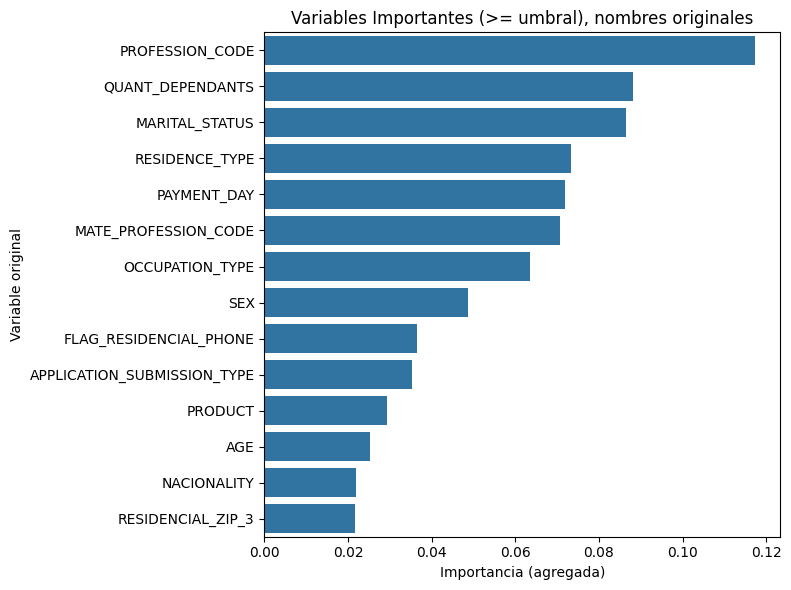

In [5]:
import pandas as pd

from ml_creditrisk.importance import (
    train_xgb_and_agg_importances,
    build_filtered_preprocessor,
    plot_importances,
    dropped_variables_table,
)

# ======================
# 🔍 Importancia de variables (XGBoost) y filtrado por umbral
# ======================

# Entrenar XGB + obtener importancias agregadas por variable original
agg_importances, pipeline_xgb = train_xgb_and_agg_importances(
    preprocessor=preprocessor,
    X_train=X_train,
    y_train=y_train,
    random_state=42,
    scale_pos_weight=2.8,
)

# Umbral de importancia
IMPORTANCE_THRESHOLD = 0.02
important_vars = agg_importances[agg_importances >= IMPORTANCE_THRESHOLD].index.tolist()
dropped_vars = [v for v in agg_importances.index if v not in important_vars]
print(f"\n🔎 Umbral de importancia = {IMPORTANCE_THRESHOLD}")
print(f"✅ Variables conservadas: {len(important_vars)} | ❌ Eliminadas: {len(dropped_vars)}")

# Tabla de eliminadas con su importancia y el umbral
dropped_df = dropped_variables_table(agg_importances, IMPORTANCE_THRESHOLD)
if len(dropped_df) > 0:
    print(f"❌ Eliminadas ({len(dropped_df)}) con su importancia y umbral:")
    display(dropped_df)
else:
    print("❌ Eliminadas (0)")

# Construir preprocessor filtrado
preprocessor_filtered = build_filtered_preprocessor(df_groups_final, df_model, important_vars)
print("✅ preprocessor_filtered creado con las variables por encima del umbral.")

# Visualizar Top-N variables ≥ umbral
plot_importances(agg_importances, threshold=IMPORTANCE_THRESHOLD, top_k=20)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd

# Asegurar que cargamos la última versión del módulo de modelos (por si fue editado en disco)
import importlib
import ml_creditrisk.models as models_mod
importlib.reload(models_mod)
from ml_creditrisk.models import get_base_models, evaluate_models

# ============================
# 🎯 Preparar datos
# ============================

X = df_model.drop(columns=['TARGET'])
y = df_model['TARGET']

# División estratificada 75/25
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"✅ División completada: Train={X_train.shape}, Test={X_test.shape}")

# ============================
# ⚙️ Modelos base
# ============================

models = get_base_models()
# Remover modelos no deseados (LR y XGB leaves + LR no se añadirán)
for key in ["Logistic Regression"]:
    models.pop(key, None)

# ============================
# 🚀 Entrenamiento + Evaluación
# ============================

# Usar el preprocesador filtrado si existe
active_preprocessor = preprocessor_filtered if 'preprocessor_filtered' in globals() else preprocessor

results_df = evaluate_models(models, active_preprocessor, X_train, X_test, y_train, y_test)

# ============================
# 📊 Resultados comparativos
# ============================

print("\n📈 Resultados de los modelos:")
display(results_df)

✅ División completada: Train=(37500, 43), Test=(12500, 43)
[LightGBM] [Info] Number of positive: 9781, number of negative: 27719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 9781, number of negative: 27719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set

c:\Users\User\Documents\Personal\Data Carrier\AnyoneAI\Final Project - Credit risk analysis\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📈 Resultados de los modelos:


,Modelo,ROC_AUC,KS,Recall (Bad=1),Precision
0,XGBoost,0.628921,0.190387,0.769018,0.312516
1,LightGBM,0.628722,0.198697,0.591411,0.343795
2,CatBoost,0.626778,0.188703,0.760429,0.311589
3,Random Forest,0.623395,0.184136,0.562577,0.339693


In [7]:
# ============================
# 🧪 Búsqueda de hiperparámetros (RandomizedSearchCV)
# ============================

# Flag para desactivar/activar la búsqueda rápidamente
HPO_ENABLED = False  # cambia a True para ejecutar la búsqueda

if not HPO_ENABLED:
    print("⏭️ Búsqueda de hiperparámetros desactivada temporalmente. Saltando esta celda.")
    # Asegurar que no se usen modelos previos por accidente
    tuned_models = {}
else:
    from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.base import clone
    import numpy as np
    import pandas as pd

    # Distribuciones para RandomizedSearchCV
    from scipy.stats import randint, uniform
    try:
        from scipy.stats import loguniform  # SciPy >= 1.4
    except Exception:
        from scipy.stats import reciprocal as loguniform  # fallback

    # Asegurar preprocesador activo
    active_preprocessor = preprocessor_filtered if 'preprocessor_filtered' in globals() else preprocessor

    # Modelos activos (ya filtrados en la celda anterior)
    models_for_search = models

    # Espacios de búsqueda por modelo (claves deben coincidir con los nombres en `models_for_search`)
    param_spaces = {
        'Random Forest': {
            'model__n_estimators': randint(150, 500),
            'model__max_depth': randint(4, 16),
            'model__min_samples_split': randint(2, 20),
            'model__min_samples_leaf': randint(1, 10),
            'model__max_features': [0.3, 0.5, 0.7, 'sqrt', 'log2'],
        },
        'XGBoost': {
            'model__n_estimators': randint(150, 500),
            'model__max_depth': randint(3, 8),
            'model__learning_rate': loguniform(1e-3, 2e-1),
            'model__subsample': uniform(0.6, 0.4),
            'model__colsample_bytree': uniform(0.6, 0.4),
            'model__min_child_weight': randint(1, 6),
            # 'model__gamma': uniform(0.0, 5.0),  # opcional
            # 'model__reg_lambda': loguniform(1e-2, 10),  # opcional
        }
    }

    # Añadir espacios si LightGBM/CatBoost están presentes
    if 'LightGBM' in models_for_search:
        param_spaces['LightGBM'] = {
            'model__n_estimators': randint(200, 600),
            'model__learning_rate': loguniform(1e-3, 2e-1),
            'model__num_leaves': randint(16, 64),
            'model__max_depth': randint(3, 10),
            'model__subsample': uniform(0.6, 0.4),
            'model__colsample_bytree': uniform(0.6, 0.4),
            'model__min_child_samples': randint(10, 60),
            # 'model__reg_alpha': loguniform(1e-3, 1e-1),
            # 'model__reg_lambda': loguniform(1e-3, 1e-1),
        }
    if 'CatBoost' in models_for_search:
        param_spaces['CatBoost'] = {
            'model__iterations': randint(200, 600),
            'model__depth': randint(4, 10),
            'model__learning_rate': loguniform(1e-3, 2e-1),
            'model__l2_leaf_reg': loguniform(1.0, 10.0),
            'model__bagging_temperature': uniform(0.0, 1.0),
            'model__random_strength': uniform(0.0, 1.0),
            # 'model__border_count': randint(32, 255),  # opcional
        }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    search_results = []
    tuned_models = {}

    for name, estimator in models_for_search.items():
        if name not in param_spaces:
            print(f"⚠️ Sin espacio de búsqueda para: {name}. Omitiendo.")
            continue

        # Construir pipeline si el estimator no es ya un Pipeline
        if isinstance(estimator, Pipeline):
            base_pipe = estimator
        else:
            base_pipe = Pipeline(steps=[('preprocessor', active_preprocessor), ('model', estimator)])

        param_dist = param_spaces[name]
        search = RandomizedSearchCV(
            estimator=base_pipe,
            param_distributions=param_dist,
            n_iter=30,
            scoring='roc_auc',
            cv=cv,
            random_state=42,
            n_jobs=-1,
            verbose=1,
            refit=True
        )
        print(f"\n🔎 Buscando hiperparámetros para: {name}...")
        search.fit(X_train, y_train)

        best_pipe = search.best_estimator_
        # Evaluación en test
        y_prob = best_pipe.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, thr = roc_curve(y_test, y_prob)
        ks = float(np.max(tpr - fpr))

        search_results.append({
            'Modelo': name,
            'Best ROC_AUC (CV)': float(search.best_score_),
            'ROC_AUC (test)': float(roc_auc),
            'KS (test)': ks,
            'Best Params': search.best_params_,
        })

        tuned_models[name] = best_pipe

    # Resumen ordenado por AUC test
    results_hpo_df = pd.DataFrame(search_results).sort_values(by='ROC_AUC (test)', ascending=False).reset_index(drop=True)
    print("\n✅ Búsqueda finalizada. Resultados (ordenados por AUC en test):")
    display(results_hpo_df)

    # Dejar `tuned_models` disponible para predicción posterior
    print(f"\n💾 Modelos ajustados disponibles en 'tuned_models' ({len(tuned_models)} modelos)")


⏭️ Búsqueda de hiperparámetros desactivada temporalmente. Saltando esta celda.


In [8]:
import pandas as pd
from sklearn.pipeline import Pipeline

# Asegurar que cargamos la última versión del módulo de modelos (por si fue editado en disco)
import importlib
import ml_creditrisk.models as models_mod
importlib.reload(models_mod)
from ml_creditrisk.models import get_base_models

# ============================
# 🔮 Predicciones sobre dataset de scoring
# ============================

# Flag para usar o no modelos ajustados por HPO
USE_TUNED_MODELS = False  # cambia a True para usar tuned_models si existen

# Asegurar columnas y rutas
path_vars = "../data/raw/PAKDD2010_VariablesList.XLS"
path_pred = "../data/raw/PAKDD2010_Prediction_Data.txt"

# Obtener lista de columnas si no existe
def _get_colnames_if_needed(path_vars: str):
    global colnames
    if 'colnames' not in globals():
        df_vars_local = pd.read_excel(path_vars)
        colnames_local = df_vars_local['Var_Title'].astype(str).tolist()
        if len(colnames_local) > 43:
            colnames_local[43] = "MATE_" + colnames_local[43]
        colnames = colnames_local

_get_colnames_if_needed(path_vars)

# Cargar dataset de predicción con los mismos nombres
df_pred = pd.read_csv(path_pred, sep="\t", header=None, names=colnames, encoding="latin1", low_memory=False)

# Conservar ID_CLIENT para el resultado si existe
id_series = df_pred['ID_CLIENT'] if 'ID_CLIENT' in df_pred.columns else pd.Series(range(len(df_pred)), name='row_id')

# El preprocesador fue entrenado sin ID_CLIENT y sin TARGET
X_pred = df_pred.drop(columns=['ID_CLIENT', 'TARGET'], errors='ignore')

# Asegurar X, y para ajustar los modelos (si no existen, crearlos)
if 'X' not in globals() or 'y' not in globals():
    X = df_model.drop(columns=['TARGET'])
    y = df_model['TARGET']

# Usar el preprocesador filtrado si existe
active_preprocessor = preprocessor_filtered if 'preprocessor_filtered' in globals() else preprocessor

# Elegir modelos: si existen `tuned_models` y se habilitó el flag, usarlos; si no, los base (sin LR)
if USE_TUNED_MODELS and 'tuned_models' in globals() and isinstance(tuned_models, dict) and len(tuned_models) > 0:
    models = tuned_models
    print(f"📦 Usando modelos ajustados (tuned_models): {list(models.keys())}")
else:
    models = get_base_models()
    for key in ["Logistic Regression"]:
        models.pop(key, None)
    print(f"⚙️ Usando modelos base: {list(models.keys())}")

# Armar pipelines, entrenar y predecir
preds = pd.DataFrame({'ID': id_series})
name_map = {
    'Random Forest': 'score_random_forest',
    'XGBoost': 'score_xgboost',
    'LightGBM': 'score_lightgbm',
    'CatBoost': 'score_catboost',
}

for name, model in models.items():
    # Si ya viene como Pipeline (caso tuned_models), úsalo; si no, envuélvelo con el preprocesador activo
    if isinstance(model, Pipeline):
        pipe = model
    else:
        pipe = Pipeline(steps=[('preprocessor', active_preprocessor), ('model', model)])

    # Reentrenar con todos los datos disponibles antes de predecir
    pipe.fit(X, y)
    y_pred_prob = pipe.predict_proba(X_pred)[:, 1]
    col_name = name_map.get(name, f"score_{name.lower().replace(' ', '_')}")
    preds[col_name] = y_pred_prob

# Adjuntar las columnas de score al df_pred para facilitar análisis y gráficos
df_pred = df_pred.copy()
for col in preds.columns:
    if col == 'ID':
        continue
    df_pred[col] = preds[col]

print(f"✅ Predicciones generadas para {len(df_pred)} filas y {len(models)} modelos")
display(preds.head())

⚙️ Usando modelos base: ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
[LightGBM] [Info] Number of positive: 13041, number of negative: 36959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 13041, number of negative: 36959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data point

c:\Users\User\Documents\Personal\Data Carrier\AnyoneAI\Final Project - Credit risk analysis\ML_CreditRisk\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Predicciones generadas para 20000 filas y 4 modelos


,ID,score_random_forest,score_xgboost,score_lightgbm,score_catboost
0,70001,0.589320,0.634576,0.564631,0.622501
1,70002,0.517897,0.559704,0.434189,0.558879
2,70003,0.535963,0.583631,0.560669,0.587821
3,70004,0.388535,0.498500,0.448981,0.495868
4,70005,0.403503,0.585093,0.494259,0.581435



📊 Estadísticas para score_random_forest
count    20000.000000
mean         0.520782
std          0.109726
min          0.230255
25%          0.466764
50%          0.546615
75%          0.603196
max          0.732554
Name: score_random_forest, dtype: float64

📊 Estadísticas para score_xgboost
count    20000.000000
mean         0.600462
std          0.111509
min          0.231066
25%          0.535234
50%          0.625924
75%          0.683735
max          0.817640
Name: score_xgboost, dtype: float64

📊 Estadísticas para score_lightgbm
count    20000.000000
mean         0.545600
std          0.123556
min          0.075595
25%          0.472237
50%          0.572695
75%          0.638322
max          0.824923
Name: score_lightgbm, dtype: float64

📊 Estadísticas para score_catboost
count    20000.000000
mean         0.592848
std          0.114536
min          0.163114
25%          0.525134
50%          0.623115
75%          0.680102
max          0.833763
Name: score_catboost, dtype: floa

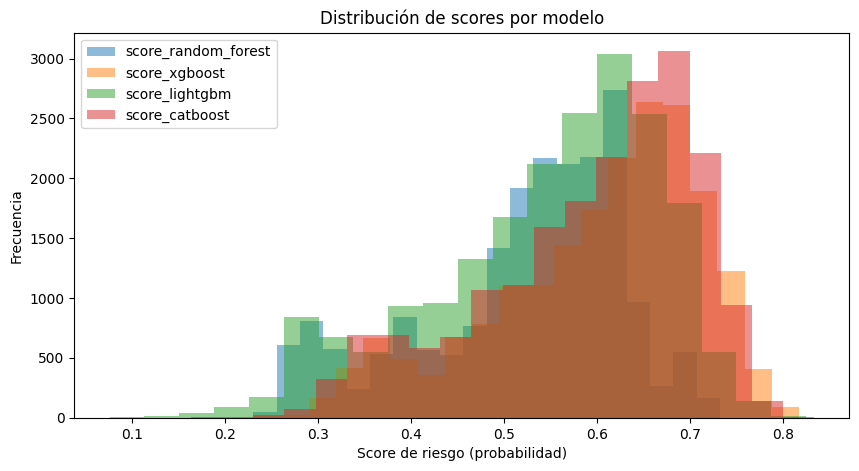

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que las columnas de score estén disponibles en df_pred
candidate_cols = ['score_random_forest', 'score_xgboost', 'score_lightgbm', 'score_catboost']
score_cols = [c for c in candidate_cols if c in df_pred.columns]

if not score_cols:
    # Intentar tomarlas desde `preds` si existen
    if 'preds' in globals():
        for c in candidate_cols:
            if c in preds.columns and c not in df_pred.columns:
                df_pred[c] = preds[c].values
        score_cols = [c for c in candidate_cols if c in df_pred.columns]

if not score_cols:
    raise RuntimeError("No hay columnas de score en df_pred. Ejecuta la celda de predicciones antes de este gráfico.")

# Distribución general de scores por modelo
plt.figure(figsize=(10, 5))
for col in score_cols:
    print(f"\n📊 Estadísticas para {col}")
    print(df_pred[col].describe())
    plt.hist(df_pred[col], bins=20, alpha=0.5, label=col)

plt.legend()
plt.title("Distribución de scores por modelo")
plt.xlabel("Score de riesgo (probabilidad)")
plt.ylabel("Frecuencia")
plt.show()


In [10]:
# Guardar preprocesador activo a models/preprocessor_active_<timestamp>.joblib (+ metadata JSON)
from pathlib import Path
import time
import json
import joblib

# 1) Elegir el preprocesador activo de forma robusta
if 'active_preprocessor' in globals():
    preprocessor_to_save = active_preprocessor
elif 'preprocessor_filtered' in globals():
    preprocessor_to_save = preprocessor_filtered
else:
    preprocessor_to_save = preprocessor  # construido desde df_groups_final

# 2) Definir datos para el ajuste del preprocesador (X_fit, y_fit)
if 'X_train' in globals() and 'y_train' in globals():
    X_fit, y_fit = X_train, y_train
else:
    X_fit = df_model.drop(columns=['TARGET'])
    y_fit = df_model['TARGET']

# 3) Ajustar preprocesador y persistir
ROOT_PATH = ROOT if 'ROOT' in globals() else Path.cwd().resolve().parent
MODELS_DIR = ROOT_PATH / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

ts = time.strftime('%Y%m%d_%H%M%S')
joblib_path = MODELS_DIR / f'preprocessor_active_{ts}.joblib'

print("🛠️ Ajustando preprocesador sobre:", "X_train/y_train" if 'X_train' in globals() else "df_model")
preprocessor_to_save.fit(X_fit, y_fit)
joblib.dump(preprocessor_to_save, joblib_path)

# 4) Guardar metadatos útiles
metadata = {
    "created_at": ts,
    "variables_source": "df_groups_final",
    "importance_threshold": float(IMPORTANCE_THRESHOLD) if 'IMPORTANCE_THRESHOLD' in globals() else None,
    "fitted_on": "X_train" if 'X_train' in globals() else "df_model",
    "shapes": {"X_fit": list(X_fit.shape), "y_fit": int(len(y_fit))},
    "blocks": (lists if 'lists' in globals() else None),
}
with open(joblib_path.with_suffix('.json'), 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(f"✅ Preprocesador guardado en: {joblib_path}")
print(f"📝 Metadatos: {joblib_path.with_suffix('.json')}")

# 5) Sanity check rápido de carga/transform
pp = joblib.load(joblib_path)
try:
    Xt_sample = pp.transform(X_fit.iloc[:5])
    print("🔎 Transform shape (muestra):", getattr(Xt_sample, 'shape', 'desconocido'))
except Exception as e:
    print("⚠️ Transform de prueba falló (esto no invalida el guardado). Error:", e)

🛠️ Ajustando preprocesador sobre: X_train/y_train
✅ Preprocesador guardado en: C:\Users\User\Documents\Personal\Data Carrier\AnyoneAI\Final Project - Credit risk analysis\ML_CreditRisk\models\preprocessor_active_20251101_210457.joblib
📝 Metadatos: C:\Users\User\Documents\Personal\Data Carrier\AnyoneAI\Final Project - Credit risk analysis\ML_CreditRisk\models\preprocessor_active_20251101_210457.json
🔎 Transform shape (muestra): (5, 97)
🔎 Transform shape (muestra): (5, 97)
